In [1]:
from google.colab import drive
drive.mount("/content/drive/")
!ln -s /content/drive/MyDrive/colabhome /drive
#!wget -P "/drive" "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
#!cd /drive && mkdir snli && mv snli_1.0.zip snli && cd snli && unzip snli_1.0.zip
#!ls -lh /drive/snli

Mounted at /content/drive/


In [2]:
import json
import numpy as np
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

with open("/drive/snli/snli_1.0/snli_1.0_train.jsonl", 'r') as f:
  snli = [json.loads(jline) for jline in f.readlines()]
with open("/drive/snli/snli_1.0/snli_1.0_test.jsonl", 'r') as f:
  snli_test = [json.loads(jline) for jline in f.readlines()]

tokenizer = Tokenizer()
corpus = [e["sentence1"] for e in snli] + [e["sentence2"] for e in snli] \
       + [e["sentence1"] for e in snli_test] + [e["sentence2"] for e in snli_test]
tokenizer.fit_on_texts(corpus)
total_unique_words = len(tokenizer.word_index) + 1 # 0 padding
print(total_unique_words)

seqs = tokenizer.texts_to_sequences(corpus)

max_seq_len = max([len(x) for x in seqs])

#!cd /drive/glove && unzip glove.6B.zip
embeddings_path = "/drive/glove/glove.6B.100d.txt"

embeddings_index = {}

with open(embeddings_path) as f:
  for line in f:
    values = line.split(" ")
    word = values[0]
    coeffs = np.array(values[1:], dtype = "float32")
    embeddings_index[word] = coeffs

embeddings_matrix = np.zeros((total_unique_words, 100))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector
  else:
    embeddings_matrix[i] = np.random.rand(100) - 0.5 # out of vocab embedding

34645


In [3]:
def preprocess(snli, tokenizer):
    data = {"premises": [], "hypotheses": [], "labels": []}
    for entry in snli:
        if entry["gold_label"] not in ["neutral", "entailment", "contradiction"]:
            continue
        data["premises"].append(tokenizer.texts_to_sequences([entry["sentence1"]])[0])
        data["hypotheses"].append(tokenizer.texts_to_sequences([entry["sentence2"]])[0])
        if entry["gold_label"] == "neutral":
            label = 0
        elif entry["gold_label"] == "entailment":
            label = 1
        elif entry["gold_label"] == "contradiction":
            label = 2
        data["labels"].append(label)
    data["premises"] = np.array(pad_sequences(data["premises"], maxlen=max_seq_len, padding='pre'))
    data["hypotheses"] = np.array(pad_sequences(data["hypotheses"], maxlen=max_seq_len, padding='pre'))
    data["labels"] = tf.keras.utils.to_categorical(data["labels"], num_classes=3)
    return data
    
data = preprocess(snli, tokenizer)
data_test = preprocess(snli_test, tokenizer)

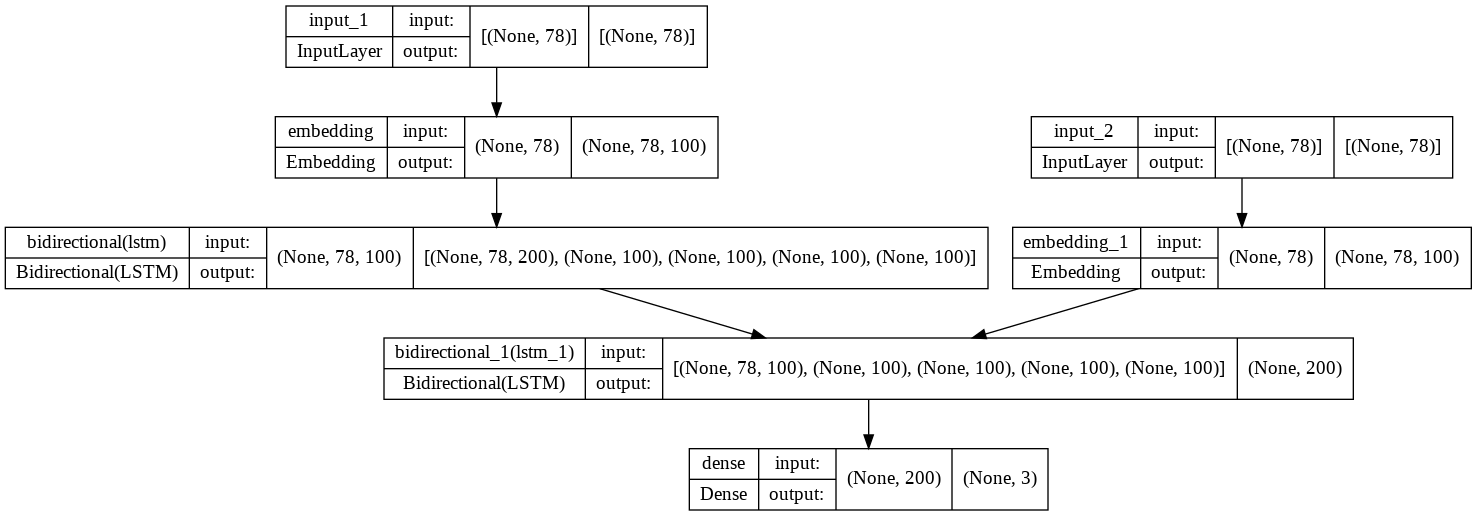

In [4]:
K.clear_session()

def get_basic_model():
    inp_pre = tf.keras.Input((max_seq_len,)) # is 78
    x = Embedding(input_dim = total_unique_words, output_dim=100, weights=[embeddings_matrix], input_length=max_seq_len, trainable=False)(inp_pre)
    x, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(100, return_sequences=True, return_state=True))(x) # premise

    hidden = [forward_h, forward_c, backward_h, backward_c]

    inp_hyp = tf.keras.Input((max_seq_len,))
    x = Embedding(input_dim = total_unique_words, output_dim=100, weights=[embeddings_matrix], input_length=max_seq_len, trainable=False)(inp_hyp)
    x = Bidirectional(LSTM(100))(x, initial_state=hidden) # hypothesis
    output = Dense(3, activation='softmax')(x)
    return tf.keras.Model([inp_pre,inp_hyp], output, name="m")

model = get_basic_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
tf.keras.utils.plot_model(model, show_shapes=True)

In [5]:
!mkdir -p /drive/snli_final/
checkpoint_path = "/drive/snli_final/noattention_test.ckpt"
#model.load_weights(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)
#loss, acc = model.evaluate(x_values, y_values, verbose=2)
#history = model.fit(x_values, y_values, epochs=40, validation_split=0.2, verbose=1, batch_size=256, callbacks=[checkpoint_callback])

history = model.fit([data["premises"], data["hypotheses"]], data["labels"], epochs=20, validation_data=([data_test["premises"], data_test["hypotheses"]], data_test["labels"]), verbose=1, batch_size=256, callbacks=[checkpoint_callback])

Epoch 1/20
2145/2146 [============================>.] - ETA: 0s - loss: 0.8690 - accuracy: 0.5993
Epoch 1: saving model to /drive/snli_final/noattention_test.ckpt
2146/2146 [==============================] - 71s 29ms/step - loss: 0.8689 - accuracy: 0.5993 - val_loss: 0.8150 - val_accuracy: 0.6401
Epoch 2/20
2146/2146 [==============================] - ETA: 0s - loss: 0.7955 - accuracy: 0.6459
Epoch 2: saving model to /drive/snli_final/noattention_test.ckpt
2146/2146 [==============================] - 64s 30ms/step - loss: 0.7955 - accuracy: 0.6459 - val_loss: 0.7657 - val_accuracy: 0.6678
Epoch 3/20
2145/2146 [============================>.] - ETA: 0s - loss: 0.7444 - accuracy: 0.6726
Epoch 3: saving model to /drive/snli_final/noattention_test.ckpt
2146/2146 [==============================] - 63s 29ms/step - loss: 0.7444 - accuracy: 0.6727 - val_loss: 0.7232 - val_accuracy: 0.6883
Epoch 4/20
2145/2146 [============================>.] - ETA: 0s - loss: 0.7163 - accuracy: 0.6886
Epoch 4:

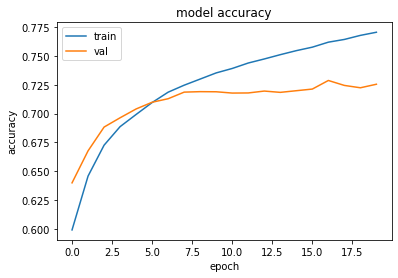

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#loss, acc = model.evaluate([data_test["premises"], data_test["hypotheses"]], data_test["labels"], verbose=2)

In [31]:
def prediction(premise, hypothesis): 
    token_list_premise = tokenizer.texts_to_sequences([premise])[0]
    token_list_premise = pad_sequences([token_list_premise], maxlen=max_seq_len, padding='pre')
    token_list_hypothesis = tokenizer.texts_to_sequences([hypothesis])[0]
    token_list_hypothesis = pad_sequences([token_list_hypothesis], maxlen=max_seq_len, padding='pre')

    predicted = np.argmax(model.predict([token_list_premise, token_list_hypothesis], verbose=0), axis=-1)
    outcomes = ("Neutral", "Entailment", "Contradiction")
    print('"{}", "{}": {}'.format(premise, hypothesis, outcomes[predicted[0]]))

prediction("A man eats a nice meal.", "The man is happy.")
prediction("A man eats a nice meal.", "The man is sad.")
prediction("A man eats a nice meal.", "The man is sitting.")
prediction("A man eats a nice meal.", "The man is standing.")
prediction("A man eats a nice meal at the table.", "The man is sitting.")
prediction("A man eats a nice meal at the table.", "The man is standing.")
prediction("A man eats a nice meal while standing.", "The man is sitting.")
prediction("A man eats a nice meal while standing.", "The man is standing.")

"A man eats a nice meal.", "The man is happy.": Neutral
"A man eats a nice meal.", "The man is sad.": Entailment
"A man eats a nice meal.", "The man is sitting.": Entailment
"A man eats a nice meal.", "The man is standing.": Contradiction
"A man eats a nice meal at the table.", "The man is sitting.": Entailment
"A man eats a nice meal at the table.", "The man is standing.": Contradiction
"A man eats a nice meal while standing.", "The man is sitting.": Entailment
"A man eats a nice meal while standing.", "The man is standing.": Contradiction
